# ML Final Project - Ad Fraud Detection 

In [3]:
#!gsutil cp gs://ad-fraud-detection-train/train.csv /home/jupyter

Copying gs://ad-fraud-detection-train/train.csv...
\ [1 files][  7.0 GiB/  7.0 GiB]   77.5 MiB/s                                   
Operation completed over 1 objects/7.0 GiB.                                      


In [9]:
#!pip install --user feather-format

  Created wheel for feather-format: filename=feather_format-0.4.0-cp35-none-any.whl size=4255 sha256=8ad9c17a6f778afce638e0444b4842336e164f1206d52c0158b89fa407e6e953
  Stored in directory: /home/jupyter/.cache/pip/wheels/85/7d/12/2dfa5c0195f921ac935f5e8f27deada74972edc0ae9988a9c1
Successfully built feather-format
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.ticker as ticker

import gc # This module provides access to the garbage collector for reference cycles. (i.e. cleans out working memory)

import seaborn as sns
import math

from sklearn.metrics import roc_auc_score, classification_report


plt.rcParams['font.size'] = 15

sns.set(font_scale=1.5)

%matplotlib inline

In [2]:
import os, psutil

#Check CPU Memory Usage 
def cpuStats():
    pid = os.getpid()
    py = psutil.Process(pid)
    memoryUse = py.memory_info()[0] / 2. ** 30
    print('memory GB:', memoryUse)

In [5]:
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32',
        }

keep_cols = ['ip','app','device','os','channel','click_time','is_attributed']

ads_extended = pd.read_csv('train.csv', usecols = keep_cols, dtype = dtypes)#, parse_dates=['click_time'])

In [14]:
cpuStats()

memory GB: 10.451622009277344


## Data fields
Dataset: https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/data

Useful Kernels:
- https://www.kaggle.com/leadbest/how-to-use-attributed-time-for-regression
- https://www.kaggle.com/pranav84/lightgbm-fixing-unbalanced-data-lb-0-9680

#### Each row of the training data contains a click record, with the following features.

- ip: ip address of click.
- app: app id for marketing.
- device: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
- os: os version id of user mobile phone
- channel: channel id of mobile ad publisher
- click_time: timestamp of click (UTC)
- attributed_time: if user download the app for after clicking an ad, this is the time of the app download
- is_attributed: the target that is to be predicted, indicating the app was downloaded

Note that ip, app, device, os, and channel are encoded.

#### The test data is similar, with the following differences:

- click_id: reference for making predictions
- is_attributed: not included

## Splitting out the click_time 

In [10]:
ads_extended['click_time'] = pd.to_datetime(ads_extended['click_time'])

In [11]:
#Split out the clicktime
ads_extended['day_of_week'] = ads_extended['click_time'].dt.dayofweek.astype('uint8')
ads_extended['hour'] = ads_extended['click_time'].dt.hour.astype('uint8')
ads_extended['minute'] = ads_extended['click_time'].dt.minute.astype('uint8')
ads_extended['second'] = ads_extended['click_time'].dt.second.astype('uint8')
ads_extended.head()

,ip,app,device,os,channel,click_time,is_attributed,day_of_week,hour,minute,second
0,83230,3,1,13,379,2017-11-06 14:32:21,0,0,14,32,21
1,17357,3,1,19,379,2017-11-06 14:33:34,0,0,14,33,34
2,35810,3,1,13,379,2017-11-06 14:34:12,0,0,14,34,12
3,45745,14,1,13,478,2017-11-06 14:34:52,0,0,14,34,52
4,161007,3,1,13,379,2017-11-06 14:35:08,0,0,14,35,8


In [12]:
ads_extended.drop(['click_time'], axis = 1, inplace = True)

In [21]:
ads_extended.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184903890 entries, 0 to 184903889
Data columns (total 10 columns):
ip               uint32
app              uint16
device           uint16
os               uint16
channel          uint16
is_attributed    uint8
day_of_week      uint8
hour             uint8
minute           uint8
second           uint8
dtypes: uint16(4), uint32(1), uint8(5)
memory usage: 2.9 GB


In [ ]:
# train_df = do_var( train_df, ['ip', 'day', 'channel'], 'hour', 'ip_tchan_count', show_max=True ); gc.collect()
# train_df = do_var( train_df, ['ip', 'app', 'os'], 'hour', 'ip_app_os_var', show_max=True ); gc.collect()
# train_df = do_var( train_df, ['ip', 'app', 'channel'], 'day', 'ip_app_channel_var_day', show_max=True ); gc.collect()
# train_df = do_mean( train_df, ['ip', 'app', 'channel'], 'hour', 'ip_app_channel_mean_hour', show_max=True ); gc.collect()


In [22]:
cpuStats()

memory GB: 10.46978759765625


# EDA 

In [23]:
#Unique value for different cols
print('Number of unique devices: ', ads_extended.device.nunique())
print('Number of unique apps: ', ads_extended.app.nunique())
print('Number of unique os: ', ads_extended.os.nunique())
print('Number of unique ips: ', ads_extended.ip.nunique())
print('Number of unique channels: ', ads_extended.channel.nunique())

Number of unique devices:  3475
Number of unique apps:  706
Number of unique os:  800
Number of unique ips:  277396
Number of unique channels:  202


In [24]:
categorical_counts = pd.DataFrame(ads_extended.iloc[:,:5].nunique(), columns = ['Unique_Count'])

In [25]:
categorical_counts["Unique_Count"].argsort()#.sort_values(ascending = False)

ip         4
app        1
device     3
os         2
channel    0
Name: Unique_Count, dtype: int64

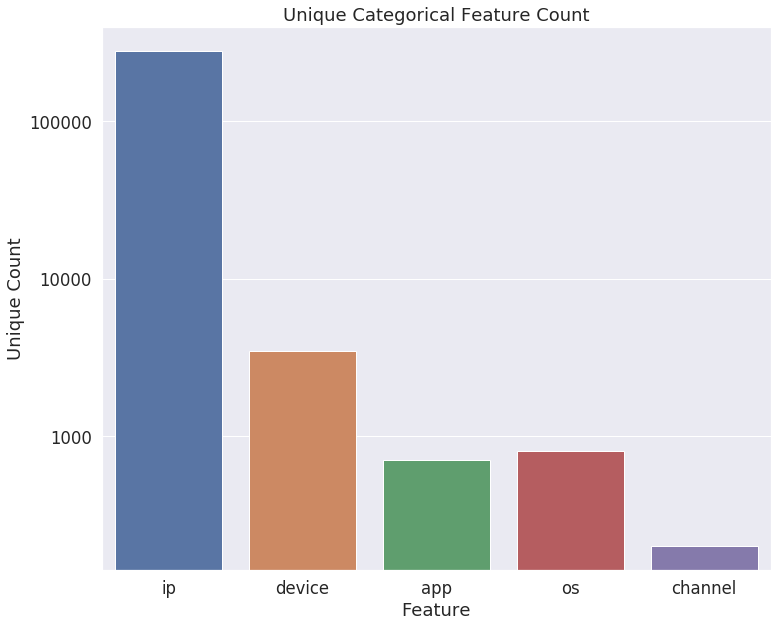

In [26]:
fig, ax = plt.subplots(figsize = (12,10))
ax = sns.barplot(x = categorical_counts.index ,y = 'Unique_Count', data = categorical_counts, order= ['ip', 'device', 'app', 'os', 'channel'])
plt.yscale('log')

plt.title('Unique Categorical Feature Count')
plt.ylabel('Unique Count')
plt.xlabel('Feature')

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))

In [27]:
del categorical_counts
gc.collect()
cpuStats()

memory GB: 10.47219467163086


## Analyzing trends by hour

In [68]:
hour_summary = ads_extended.groupby('hour').agg({'is_attributed':['sum', 'mean'],
                                 'app': lambda x: x.nunique()}).reset_index()

hour_summary

hour is_attributed                app
                  sum      mean <lambda>
0     0       21696.0  0.002083      344
1     1       27846.0  0.002945      359
2     2       29408.0  0.003016      371
3     3       28861.0  0.002962      382
4     4       29235.0  0.002605      379
5     5       26531.0  0.002637      375
6     6       25757.0  0.002719      373
7     7       25653.0  0.002769      382
8     8       25316.0  0.002950      372
9     9       24725.0  0.002742      379
10   10       24397.0  0.002444      391
11   11       26051.0  0.002628      391
12   12       26484.0  0.002689      406
13   13       25798.0  0.002502      402
14   14       21596.0  0.002100      372
15   15       13191.0  0.001430      349
16   16       12098.0  0.001709      345
17   17        6938.0  0.001773      304
18   18        4378.0  0.001938      268
19   19        3259.0  0.002111      251
20   20        2948.0  0.002328      250
21   21        3896.0  0.002467      268
22   22        7763.0  0.002123      301
23   23       13021.0  0.001844      331

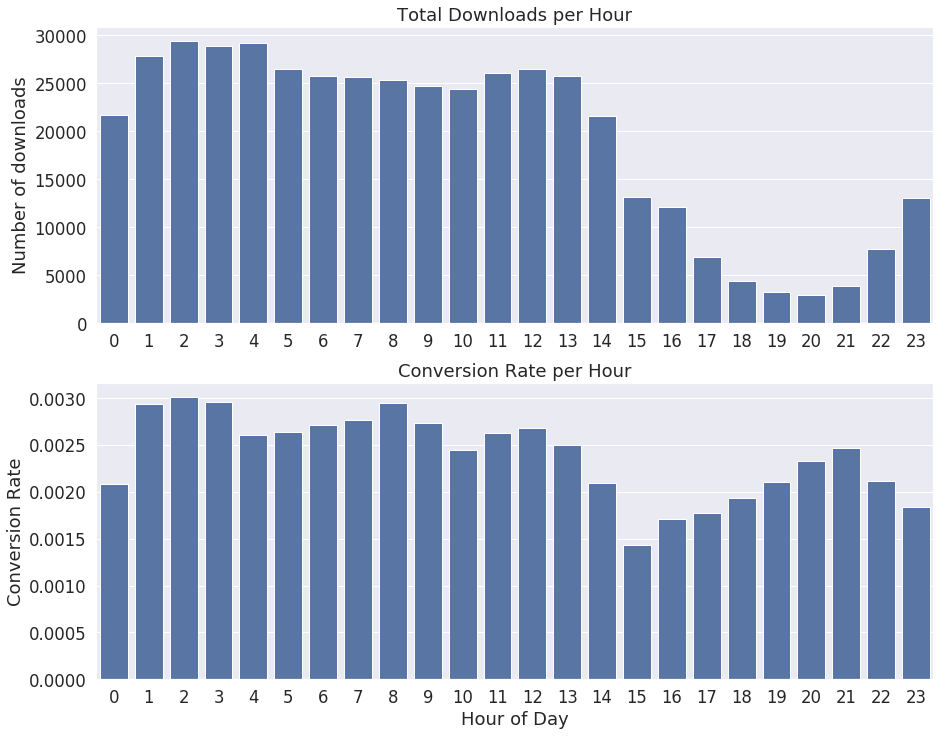

In [29]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize=(15,12), sharex='row')

sns.barplot(x = ( 'hour',''), y = ('is_attributed','sum'), color = 'b', data = hour_summary, ax = ax1)
ax1.set_ylabel('Number of downloads')
ax1.set_xlabel('')
ax1.title.set_text('Total Downloads per Hour')

sns.barplot(x = ( 'hour',''), y = ('is_attributed','mean'), color = 'b', data = hour_summary, ax = ax2)
ax2.set_ylabel('Conversion Rate')
ax2.set_xlabel('Hour of Day')
ax2.title.set_text('Conversion Rate per Hour')


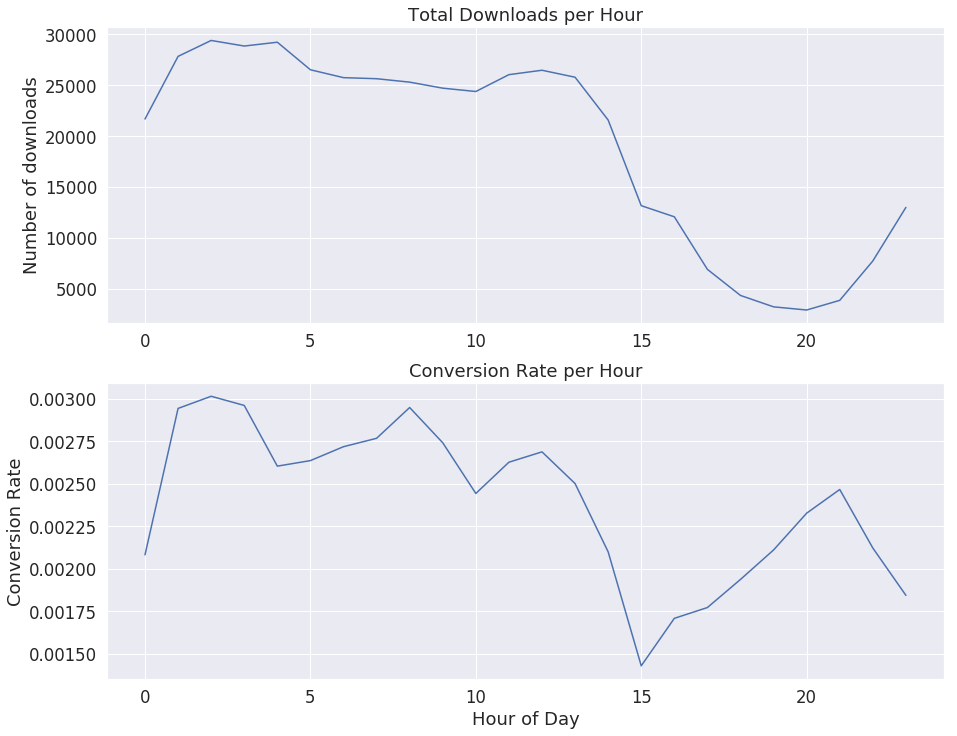

In [69]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize=(15,12), sharex='row')

sns.lineplot(x = ( 'hour',''), y = ('is_attributed','sum'), color = 'b', data = hour_summary, ax = ax1)
ax1.set_ylabel('Number of downloads')
ax1.set_xlabel('')
ax1.title.set_text('Total Downloads per Hour')

sns.lineplot(x = ( 'hour',''), y = ('is_attributed','mean'), color = 'b', data = hour_summary, ax = ax2)
ax2.set_ylabel('Conversion Rate')
ax2.set_xlabel('Hour of Day')
ax2.title.set_text('Conversion Rate per Hour')

In [80]:
del hour_summary
gc.collect()
cpuStats()

NameError: name 'hour_summary' is not defined

## Number of downloads per OS and OS conversion rate 

In [81]:
OS_summary = ads_extended.groupby('os').agg({'is_attributed':['sum', 'mean']}).reset_index()
OS_summary = OS_summary.sort_values(('is_attributed','sum'), ascending = False)
OS_summary

os is_attributed          
                   sum      mean
19    19       79669.0  0.001803
13    13       61622.0  0.001549
24    24       47461.0  0.126777
0      0       38039.0  0.104272
29    29       19534.0  0.188840
..   ...           ...       ...
338  375           0.0  0.000000
339  376           0.0  0.000000
340  377           0.0  0.000000
341  379           0.0  0.000000
799  956           0.0  0.000000

[800 rows x 3 columns]

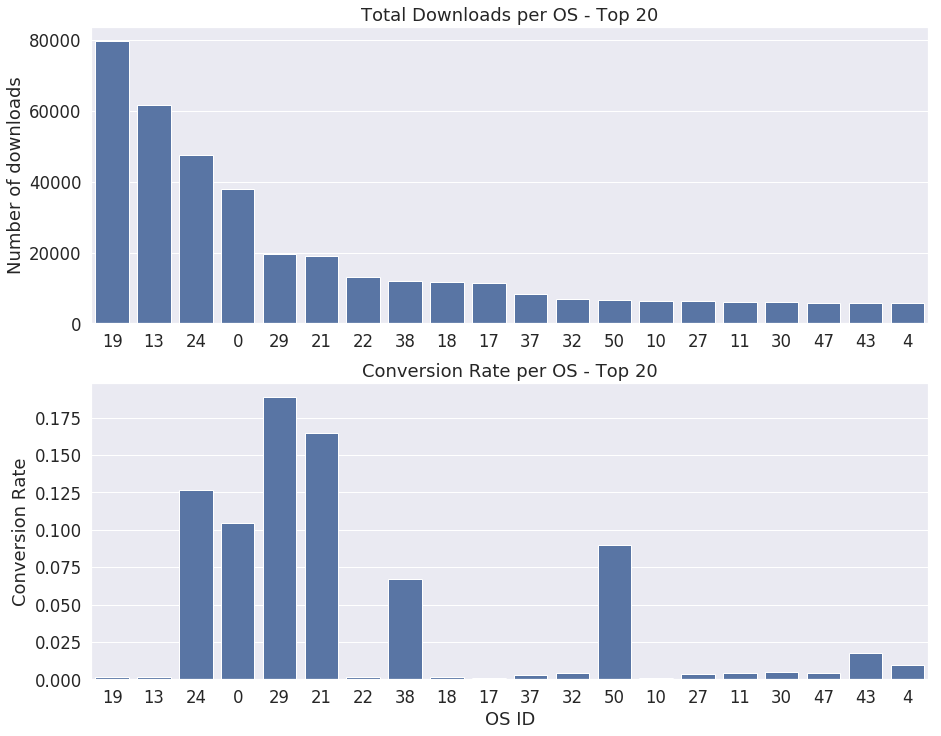

In [82]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize=(15,12), sharex='row')

sns.barplot(x = ( 'os',''), y = ('is_attributed','sum'), color = 'b', data = OS_summary[:20], ax = ax1, order = list(OS_summary.os[:20].values))
ax1.set_ylabel('Number of downloads')
ax1.set_xlabel('')
ax1.title.set_text('Total Downloads per OS - Top 20')

sns.barplot(x = ( 'os',''), y = ('is_attributed','mean'), color = 'b', data = OS_summary[:20], ax = ax2, order = list(OS_summary.os[:20].values))
ax2.set_ylabel('Conversion Rate')
ax2.set_xlabel('OS ID')
ax2.title.set_text('Conversion Rate per OS - Top 20')



In [83]:
del OS_summary
gc.collect()
cpuStats()

memory GB: 9.11178207397461


## Number of downloads per OS and OS conversion rate 

In [84]:
channel_summary = ads_extended.groupby('channel').agg({'is_attributed':['sum', 'mean']}).reset_index()
channel_summary = channel_summary.sort_values(('is_attributed','sum'), ascending = False)
channel_summary

channel is_attributed          
                      sum      mean
65      213      133070.0  0.169508
21      113       55866.0  0.117789
10       21       42469.0  0.140053
15      101       33176.0  0.015451
98      274       25888.0  0.672905
..      ...           ...       ...
45      149           0.0  0.000000
44      146           0.0  0.000000
42      142           0.0  0.000000
169     455           0.0  0.000000
201     500           0.0  0.000000

[202 rows x 3 columns]

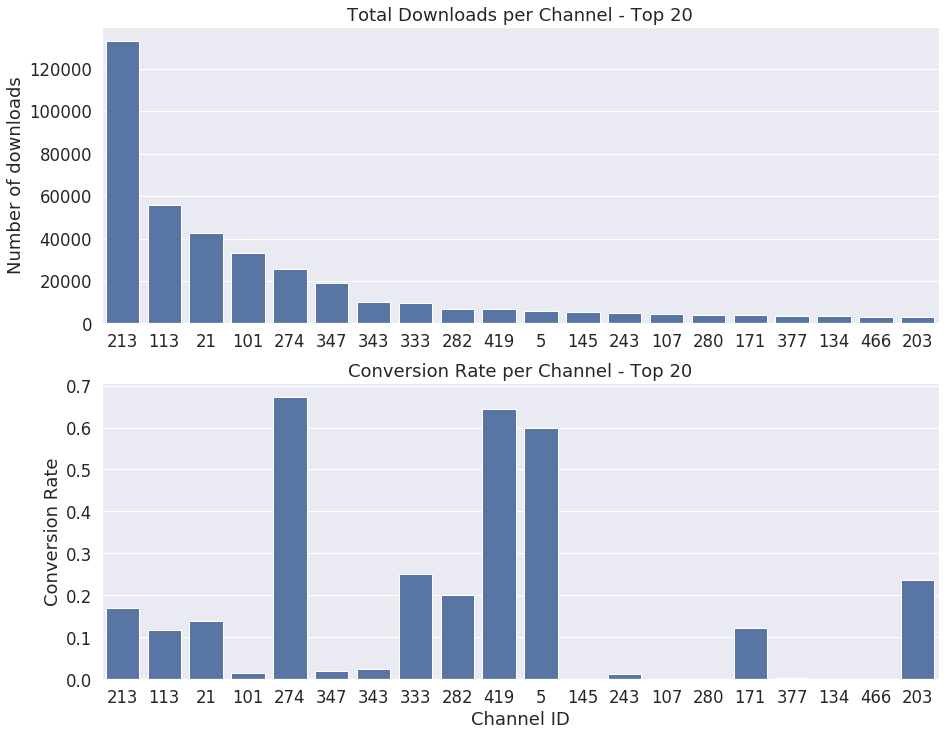

In [85]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize=(15,12), sharex='row')

sns.barplot(x = ( 'channel',''), y = ('is_attributed','sum'), color = 'b', data = channel_summary[:20], ax = ax1, order = list(channel_summary.channel[:20].values))
ax1.set_ylabel('Number of downloads')
ax1.set_xlabel('')
ax1.title.set_text('Total Downloads per Channel - Top 20')

sns.barplot(x = ( 'channel',''), y = ('is_attributed','mean'), color = 'b', data = channel_summary[:20], ax = ax2, order = list(channel_summary.channel[:20].values))
ax2.set_ylabel('Conversion Rate')
ax2.set_xlabel('Channel ID')
ax2.title.set_text('Conversion Rate per Channel - Top 20')



In [75]:
del channel_summary
gc.collect()
cpuStats()

memory GB: 9.11178207397461


## Number of downloads per App and APP conversion rate 

In [76]:
app_summary = ads_extended.groupby('app').agg({'is_attributed':['sum', 'mean']}).reset_index()
app_summary = app_summary.sort_values(('is_attributed','sum'), ascending = False)
app_summary

app is_attributed          
                   sum      mean
19    19      132390.0  0.143450
35    35       64279.0  0.705541
29    29       39957.0  0.061275
10    10       34578.0  0.050549
5      5       27263.0  0.072598
..   ...           ...       ...
362  378           0.0  0.000000
361  377           0.0  0.000000
360  376           0.0  0.000000
358  373           0.0  0.000000
353  367           0.0  0.000000

[706 rows x 3 columns]

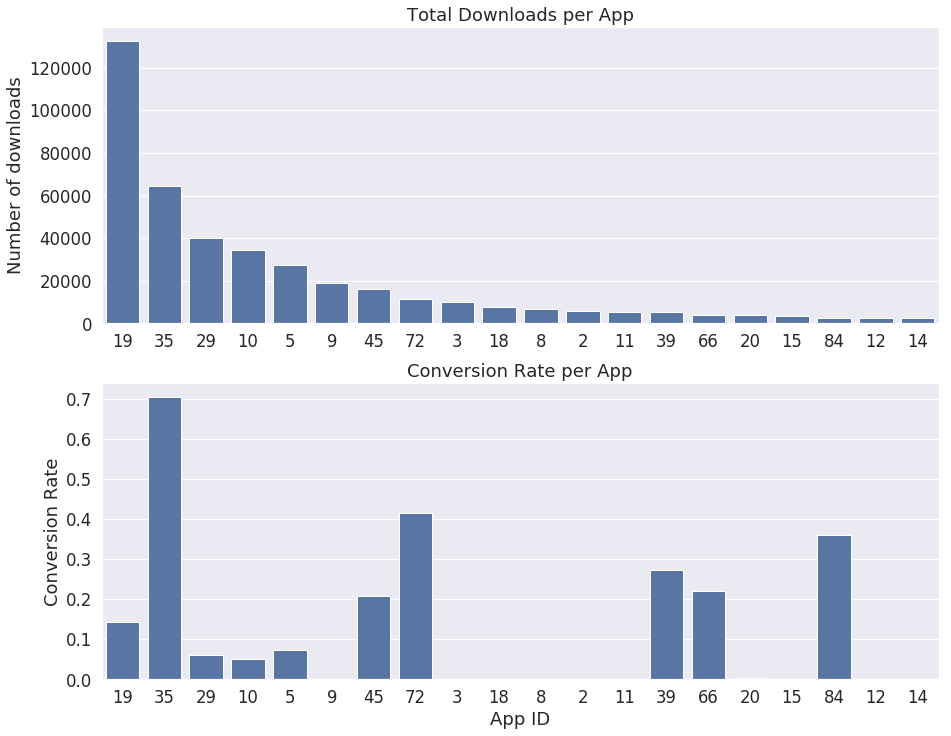

In [78]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize=(15,12), sharex='row')

sns.barplot(x = ( 'app',''), y = ('is_attributed','sum'), color = 'b', data = app_summary[:20], ax = ax1, order = list(app_summary.app[:20].values))
ax1.set_ylabel('Number of downloads')
ax1.set_xlabel('')
ax1.title.set_text('Total Downloads per App')

sns.barplot(x = ( 'app',''), y = ('is_attributed','mean'), color = 'b', data = app_summary[:20], ax = ax2, order = list(app_summary.app[:20].values))
ax2.set_ylabel('Conversion Rate')
ax2.set_xlabel('App ID')
ax2.title.set_text('Conversion Rate per App')



In [79]:
del app_summary
gc.collect()
cpuStats()

memory GB: 9.11178207397461


## Number of clicks by IP address

In [12]:
clicks_by_ip = ads_extended.groupby(['ip'])['channel'].count().reset_index().sort_values('channel', ascending = False) 
clicks_by_ip.columns = ['ip', 'clicks_by_ip']
clicks_by_ip.head()

,ip,clicks_by_ip
16011,73516,51711
16004,73487,51215
1161,5314,35073
1172,5348,35004
11714,53454,25381


Text(0.5, 1.0, 'Clicks by IP Distribution (log scale)')

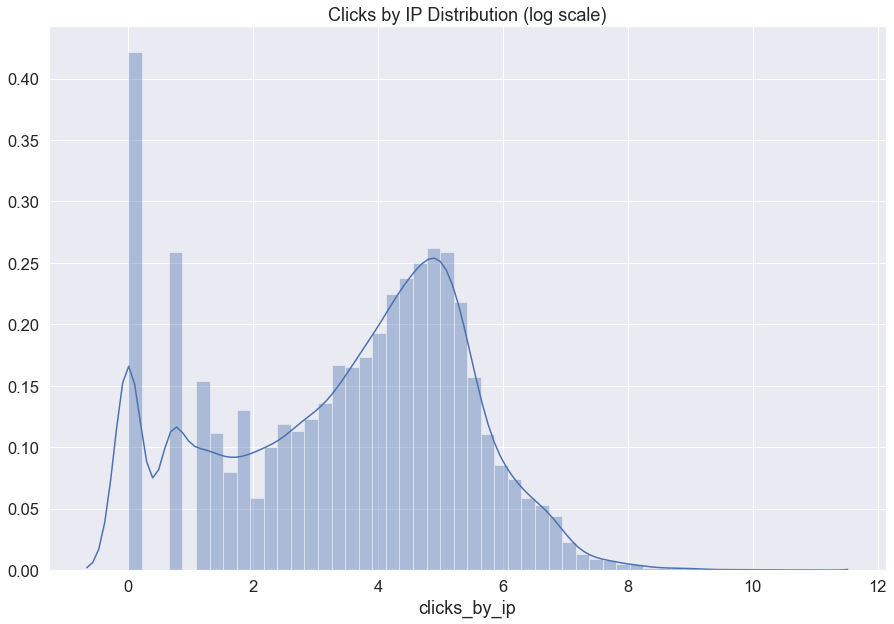

In [13]:
plt.figure(figsize=(15,10))
ax = sns.distplot(a= np.log(clicks_by_ip.clicks_by_ip))

plt.title('Clicks by IP Distribution (log scale)')

#ax.set(xticks=list(map(round, map(math.exp, np.array(list(range(0,13,2)))))))

## Ratio of different devices

In [14]:
#Device representation
percent_device = ads_extended['device'].value_counts()/ads_extended.shape[0]
percent_device = pd.DataFrame(percent_device).reset_index()

percent_device.columns = ['Device', 'Percent']

In [15]:
#Create top 2 and other categories
percent_device_top2 = percent_device[:2].copy()

percent_device_other = pd.DataFrame({'Device':['other'], 'Percent': [percent_device['Percent'][2:].sum()]})

#Merge the dfs
percent_device_grouped = pd.concat([percent_device_top2, percent_device_other])

Text(0.5, 0, 'Device ID')

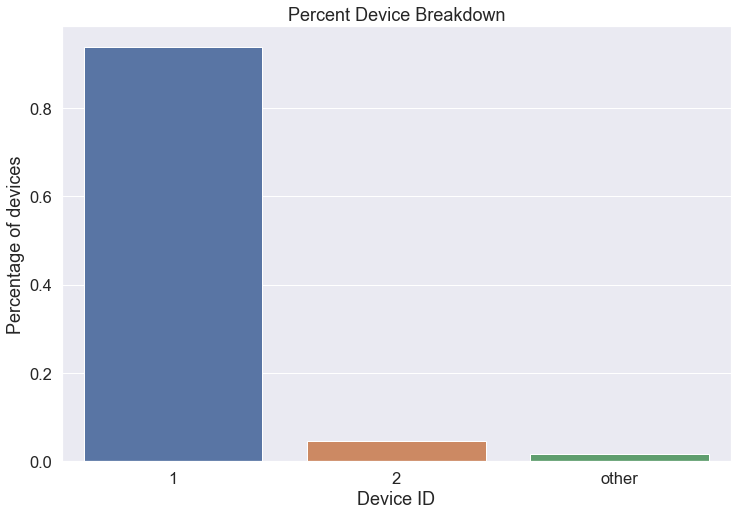

In [16]:
plt.figure(figsize=(12,8))
sns.barplot(x = 'Device', y = 'Percent', data = percent_device_grouped)
plt.title('Percent Device Breakdown')
plt.ylabel('Percentage of devices')
plt.xlabel('Device ID')

Text(0.5, 1.0, 'Percent Device Breakdown by ID')

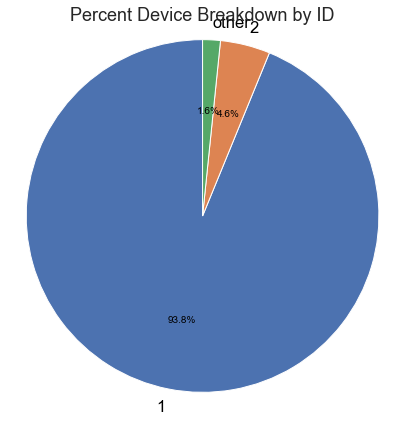

In [17]:
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots(figsize = (7,7))
patches, texts, autotexts = ax1.pie('Percent', labels='Device', autopct='%1.1f%%', startangle=90, data = percent_device_grouped)
for text in texts:
    text.set_color('black')
for autotext in autotexts:
    autotext.set_color('black')
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.title('Percent Device Breakdown by ID')


# Feature Engineering 

## Grouping columns features -- Rationale: since there are so few columns, the combination of columns will likely create important disinguishing features for the fraud addresses. 

### IP-App-Channel Conversion Rate

In [96]:
gc.collect()
cpuStats()

memory GB: 9.745193481445312


In [97]:
gp = ads_extended[['ip', 'app', 'channel', 'is_attributed']].groupby(by=['ip', 'app', 'channel'])['is_attributed'].mean().reset_index().rename(index=str, columns={'is_attributed': 'ip_app_channel_conv'})
ads_extended = ads_extended.merge(gp, on=['ip','app', 'channel'], how='left')
del gp
gc.collect()
cpuStats()

memory GB: 11.812522888183594


### IP Conversion Rate

In [99]:
gp = ads_extended[['ip', 'is_attributed']].groupby(by=['ip'])['is_attributed'].mean().reset_index().rename(index=str, columns={'is_attributed': 'ip_conv'})
ads_extended = ads_extended.merge(gp, on=['ip'], how='left')
del gp
gc.collect()
cpuStats()

memory GB: 12.501258850097656


### Channel OS Conversion Rate

In [100]:
gp = ads_extended[['channel','os', 'is_attributed']].groupby(by=['channel','os'])['is_attributed'].mean().reset_index().rename(index=str, columns={'is_attributed': 'channel_os_conv'})
ads_extended = ads_extended.merge(gp, on=['channel','os'], how='left')
del gp
gc.collect()
cpuStats()

memory GB: 14.567829132080078


### App OS Conversion Rate

In [101]:
gp = ads_extended[['app','os', 'is_attributed']].groupby(by=['app','os'])['is_attributed'].mean().reset_index().rename(index=str, columns={'is_attributed': 'app_os_conv'})
ads_extended = ads_extended.merge(gp, on=['app','os'], how='left')
del gp
gc.collect()
cpuStats()

memory GB: 15.256549835205078


## FEATHER CHECKPOINT

In [112]:
#ads_extended.to_feather('train_convfeats.feather')

In [14]:
gc.collect()
cpuStats()

memory GB: 0.2637481689453125


In [18]:
predictors = ['ip', 'app', 'device', 'os', 'channel', 'day_of_week',
       'hour', 'minute', 'second', 'ip_app_channel_conv', 'ip_conv',
       'channel_os_conv', 'app_os_conv']

In [15]:
ads_extended = pd.read_feather('train_convfeats.feather')

In [16]:
ads_extended.head()

,ip,app,device,os,channel,is_attributed,day_of_week,hour,minute,second,ip_app_channel_conv,ip_conv,channel_os_conv,app_os_conv
0,83230,3,1,13,379,0,0,14,32,21,0.0,0.001672,0.00036,0.000270
1,17357,3,1,19,379,0,0,14,33,34,0.0,0.001657,0.00041,0.000256
2,35810,3,1,13,379,0,0,14,34,12,0.0,0.000919,0.00036,0.000270
3,45745,14,1,13,478,0,0,14,34,52,0.0,0.001076,0.00625,0.000242
4,161007,3,1,13,379,0,0,14,35,8,0.0,0.000854,0.00036,0.000270


In [19]:
def do_countuniq( df, group_cols, counted, agg_type='uint8', show_max=False, show_agg=True ):
    
    agg_name= '{}_by_{}_countuniq'.format(('_'.join(group_cols)),(counted))  
    if show_agg:
        print( "\nCounting unqiue ", counted, " by ", group_cols ,  '... and saved in', agg_name )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].nunique().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    predictors.append(agg_name)
#     print('predictors',predictors)
    gc.collect()
    return( df )

In [20]:
ads_extended = do_countuniq( ads_extended, ['ip'], 'channel' ); gc.collect()
ads_extended = do_countuniq( ads_extended, ['ip', 'device', 'os'], 'app'); gc.collect()

In [23]:
ads_extended = do_countuniq( ads_extended, ['ip', 'day_of_week'], 'hour' ); gc.collect()
ads_extended = do_countuniq( ads_extended, ['ip'], 'app'); gc.collect()
ads_extended = do_countuniq( ads_extended, ['ip', 'app'], 'os'); gc.collect()
ads_extended = do_countuniq( ads_extended, ['ip'], 'device'); gc.collect()
ads_extended = do_countuniq( ads_extended, ['app'], 'channel'); gc.collect()


Counting unqiue  hour  by  ['ip', 'day_of_week'] ... and saved in ip_day_of_week_by_hour_countuniq

Counting unqiue  app  by  ['ip'] ... and saved in ip_by_app_countuniq

Counting unqiue  os  by  ['ip', 'app'] ... and saved in ip_app_by_os_countuniq

Counting unqiue  device  by  ['ip'] ... and saved in ip_by_device_countuniq

Counting unqiue  channel  by  ['app'] ... and saved in app_by_channel_countuniq


0

In [25]:
#ads_extended.to_feather('train_convcount_feats.feather')

In [104]:
#ads_extended.describe()

,ip,app,device,os,channel,is_attributed,day_of_week,hour,minute,second,ip_app_channel_conv,ip_conv,channel_os_conv,app_os_conv
count,1.849039e+08,1.849039e+08,1.849039e+08,1.849039e+08,1.849039e+08,1.849039e+08,1.849039e+08,1.849039e+08,1.849039e+08,1.849039e+08,1.849039e+08,1.849039e+08,1.849039e+08,1.849039e+08
mean,9.087604e+04,1.201131e+01,2.172325e+01,2.267702e+01,2.685789e+02,2.470721e-03,1.863532e+00,9.298776e+00,2.932644e+01,2.955944e+01,2.470721e-03,2.470721e-03,2.470721e-03,2.470721e-03
std,6.952789e+04,1.480521e+01,2.593326e+02,5.525282e+01,1.295882e+02,4.964491e-02,8.899349e-01,6.171641e+00,1.738103e+01,1.724064e+01,3.899043e-02,2.178874e-02,2.379364e-02,2.576022e-02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.024500e+04,3.000000e+00,1.000000e+00,1.300000e+01,1.400000e+02,0.000000e+00,1.000000e+00,4.000000e+00,1.400000e+01,1.500000e+01,0.000000e+00,7.528231e-04,1.215805e-04,1.192203e-04
50%,7.962200e+04,1.200000e+01,1.000000e+00,1.800000e+01,2.580000e+02,0.000000e+00,2.000000e+00,9.000000e+00,2.900000e+01,3.000000e+01,0.000000e+00,1.148106e-03,2.557264e-04,2.555921e-04
75%,1.182470e+05,1.500000e+01,1.000000e+00,1.900000e+01,3.790000e+02,0.000000e+00,3.000000e+00,1.400000e+01,4.400000e+01,4.400000e+01,0.000000e+00,1.662165e-03,5.927123e-04,4.773624e-04
max,3.647780e+05,7.680000e+02,4.227000e+03,9.560000e+02,5.000000e+02,1.000000e+00,3.000000e+00,2.300000e+01,5.900000e+01,5.900000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [27]:
gc.collect()
cpuStats()

memory GB: 30.025623321533203


## Fixing datatypes

### optimizing space using correct dtype

```
**Data type	Description**
bool_	Boolean (True or False) stored as a byte
int_	Default integer type (same as C long; normally either int64 or int32)
intc	Identical to C int (normally int32 or int64)
intp	Integer used for indexing (same as C ssize_t; normally either int32 or int64)
int8	Byte (-128 to 127)
int16	Integer (-32768 to 32767)
int32	Integer (-2147483648 to 2147483647)
int64	Integer (-9223372036854775808 to 9223372036854775807)
uint8	Unsigned integer (0 to 255)
uint16	Unsigned integer (0 to 65535)
uint32	Unsigned integer (0 to 4294967295)
uint64	Unsigned integer (0 to 18446744073709551615)
float_	Shorthand for float64.
float16	Half precision float: sign bit, 5 bits exponent, 10 bits mantissa
float32	Single precision float: sign bit, 8 bits exponent, 23 bits mantissa
float64	Double precision float: sign bit, 11 bits exponent, 52 bits mantissa
complex_	Shorthand for complex128.
complex64	Complex number, represented by two 32-bit floats
complex128	Complex number, represented by two 64-bit floats```

In [28]:
ads_extended.dtypes

ip                                   uint32
app                                  uint16
device                               uint16
os                                   uint16
channel                              uint16
is_attributed                         uint8
day_of_week                           uint8
hour                                  uint8
minute                                uint8
second                                uint8
ip_app_channel_conv                 float64
ip_conv                             float64
channel_os_conv                     float64
app_os_conv                         float64
ip_by_channel_countuniq               uint8
ip_device_os_by_app_countuniq         uint8
ip_day_of_week_by_hour_countuniq      uint8
ip_by_app_countuniq                   uint8
ip_app_by_os_countuniq                uint8
ip_by_device_countuniq                uint8
app_by_channel_countuniq              uint8
dtype: object

## Dropping some columns and splitting test & train

In [37]:
cpuStats()

memory GB: 41.74628448486328


In [3]:
cpuStats()

memory GB: 0.2921409606933594


In [4]:
ads_extended = pd.read_feather('train_convcount_feats.feather')

In [5]:
y = ads_extended['is_attributed'].values

ads_extended.drop(['is_attributed' ],axis=1,inplace=True)
gc.collect()
cpuStats()

ads_extended.head(10)

memory GB: 19.40860366821289


,ip,app,device,os,channel,day_of_week,hour,minute,second,ip_app_channel_conv,ip_conv,channel_os_conv,app_os_conv,ip_by_channel_countuniq,ip_device_os_by_app_countuniq,ip_day_of_week_by_hour_countuniq,ip_by_app_countuniq,ip_app_by_os_countuniq,ip_by_device_countuniq,app_by_channel_countuniq
0,83230,3,1,13,379,0,14,32,21,0.0,0.001672,0.000360,0.000270,139,47,9,83,47,24,49
1,17357,3,1,19,379,0,14,33,34,0.0,0.001657,0.000410,0.000256,134,45,10,73,49,21,49
2,35810,3,1,13,379,0,14,34,12,0.0,0.000919,0.000360,0.000270,135,39,9,63,51,13,49
3,45745,14,1,13,478,0,14,34,52,0.0,0.001076,0.006250,0.000242,148,58,9,145,67,85,39
4,161007,3,1,13,379,0,14,35,8,0.0,0.000854,0.000360,0.000270,94,28,7,38,21,5,49
5,18787,3,1,16,379,0,14,36,26,0.0,0.001351,0.000397,0.000386,109,20,7,50,30,2,49
6,103022,3,1,23,379,0,14,37,44,0.0,0.000533,0.000051,0.000132,107,3,9,41,39,10,49
7,114221,3,1,19,379,0,14,37,59,0.0,0.001574,0.000410,0.000256,91,28,6,38,28,4,49
8,165970,3,1,13,379,0,14,38,10,0.0,0.000497,0.000360,0.000270,93,22,7,33,32,6,49
9,74544,64,1,22,459,0,14,38,23,0.0,0.000823,0.000631,0.000902,104,18,7,47,17,6,3


# Modeling

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(ads_extended, y, test_size=0.2, random_state=42, stratify = y)

In [8]:
print('Percent of clicks-to-download in train:',round((sum(y_train)/len(X_train))*100,3),'%',
      'and in test = ', round((sum(y_test)/len(X_test))*100,3),'%')

Percent of clicks-to-download in train: 0.247 % and in test =  0.247 %


## Random Forest

In [9]:
from sklearn.ensemble import RandomForestClassifier

/usr/local/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [10]:
%%time

rfc = RandomForestClassifier(max_depth=10, min_samples_leaf=100, n_estimators = 100)

rfc.fit(X_train, y_train)

MemoryError: 

In [50]:
#Let's predict on the test set 
y_pred = rfc.predict(X_test)

#Let's also get the predicted probabilities
y_pred_probs = rfc.predict_proba(X_test)[:,1]

In [51]:
print('AUC for ROC curve = ', roc_auc_score(y_test,y_pred))

print('AUC for ROC curve = ', roc_auc_score(y_test,y_pred_probs))

AUC for ROC curve =  1.0
AUC for ROC curve =  0.9999999999999999


In [227]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1996257
           1       1.00      0.95      0.98      3743

    accuracy                           1.00   2000000
   macro avg       1.00      0.98      0.99   2000000
weighted avg       1.00      1.00      1.00   2000000



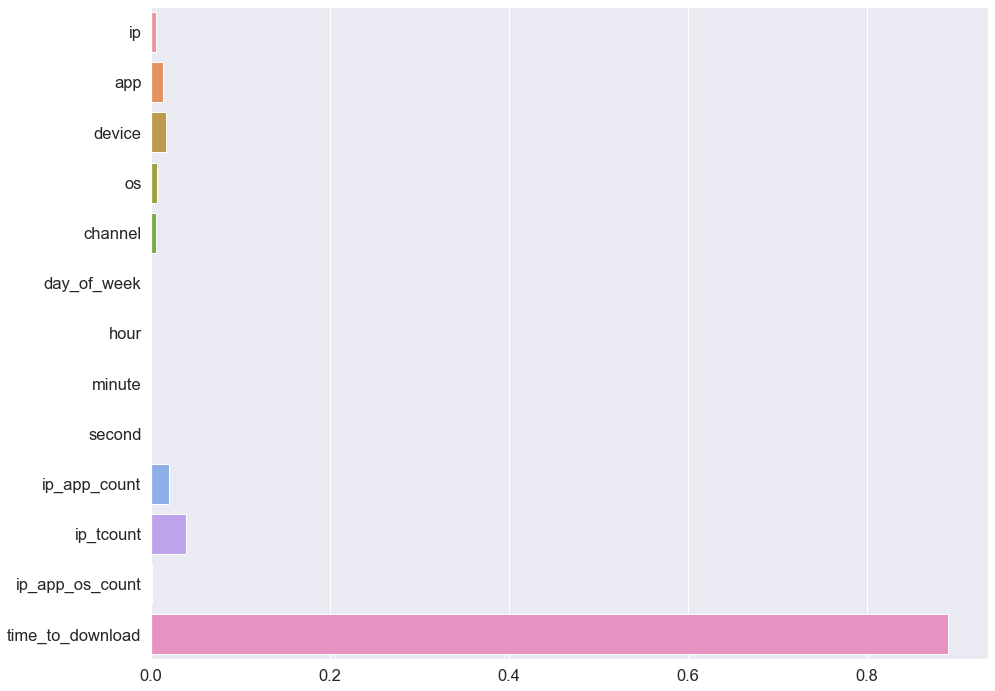

In [58]:
plt.figure(figsize=(15,12))
sns.barplot(rfc.feature_importances_, ads_extended.columns)

In [ ]:
rfc.plot_importan

In [53]:
y_pred_train = rfc.predict(X_train)

print('AUC for ROC curve = ', roc_auc_score(y_train,y_pred_train))

AUC for ROC curve =  0.9998664351542674


In [54]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   7985026
           1       1.00      1.00      1.00     14974

    accuracy                           1.00   8000000
   macro avg       1.00      1.00      1.00   8000000
weighted avg       1.00      1.00      1.00   8000000



In [230]:
gc.collect()


7582